<a href="https://colab.research.google.com/github/tasaufmim/lungCancer3modelsCompare/blob/main/LungCancerVGG16ResNet50VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets

In [ ]:
pip install pandas

In [ ]:
pip install torchsummary

In [ ]:
import opendatasets as od
import pandas
import os
import shutil
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
import torchvision.models as models

from PIL import Image, ImageEnhance
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from torchsummary import summary

In [ ]:
#Downloading the dataset
od.download(
    "https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tasaufmim
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset


100%|██████████| 199M/199M [00:00<00:00, 797MB/s] 


In [ ]:
#Checking the dataset
base_dir = '/content/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'
class_names = ['Bengin cases', 'Malignant cases', 'Normal cases']

for class_name in class_names:
    class_folder = os.path.join(base_dir, class_name);
    files = [f for f in os.listdir(class_folder)]
    print(len(files))

120
561
416


In [ ]:
#Reinitail existing folder (if any)
output_dir = "/content/balanced_dataset"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

In [ ]:
target_count = 600
img_size = (512, 512)

#Parameters of transformations
def get_random_transform():
    options = [
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
        lambda img: img.rotate(random.uniform(-25, 25)),
        lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(1.2, 1.8)),
        lambda img: ImageEnhance.Color(img).enhance(random.uniform(1.2, 2.0)),
        lambda img: ImageEnhance.Sharpness(img).enhance(random.uniform(1.5, 2.5))
    ]
    return random.choice(options)

def augment_and_save(class_name, target_count):
    class_src = os.path.join(base_dir, class_name)
    class_dst = os.path.join(output_dir, class_name)
    os.makedirs(class_dst)

    images = [f for f in os.listdir(class_src)]
    original_count = len(images)

    #copying to output folder
    for img in images:
        shutil.copy(os.path.join(class_src, img), os.path.join(class_dst, img))

    #Check if original_count < target_count
    extra_needed = target_count - original_count
    if extra_needed <= 0:
        return

    print(f"Will generate {extra_needed} new images for {class_name}")

    for i in range(extra_needed):
        img_name = random.choice(images)
        try:
            with Image.open(os.path.join(class_src, img_name)) as img:
                img = img.convert('RGB').resize(img_size)
                transformed_img = get_random_transform()(img)
                save_name = f"aug{i}_{img_name}"
                transformed_img.save(os.path.join(class_dst, save_name))
        except Exception as err:
            print(f"Error while augmenting: {err}")

for class_name in class_names:
    augment_and_save(class_name, target_count)

print("Augmentation completed")

Will generate 480 new images for Bengin cases
Will generate 39 new images for Malignant cases
Will generate 184 new images for Normal cases
Augmentation completed


Training

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet means
                         [0.229, 0.224, 0.225])  # ImageNet std
])

dataset = datasets.ImageFolder(root="/content/balanced_dataset", transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg16(pretrained=True)

#Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

#Replace the classifier
model.classifier[6] = nn.Linear(4096, 3)  #Number of classes: 3

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 183MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg16_train_losses = []
vgg16_train_accuracies = []
vgg16_val_losses = []
vgg16_val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    vgg_train_losses.append(epoch_loss)
    vgg_train_accuracies.append(epoch_acc)

    #Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    vgg16_val_losses.append(val_loss / len(val_loader))
    vgg16_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Acc: {vgg_val_accuracies[-1]:.4f}")

Epoch 1, Train Loss: 0.5418, Train Acc: 0.7514, Val Loss: 0.2828, Val Acc: 0.8917
Epoch 2, Train Loss: 0.2249, Train Acc: 0.9056, Val Loss: 0.1183, Val Acc: 0.9694
Epoch 3, Train Loss: 0.0919, Train Acc: 0.9660, Val Loss: 0.0853, Val Acc: 0.9639
Epoch 4, Train Loss: 0.0845, Train Acc: 0.9701, Val Loss: 0.1482, Val Acc: 0.9361
Epoch 5, Train Loss: 0.0601, Train Acc: 0.9771, Val Loss: 0.0487, Val Acc: 0.9889
Epoch 6, Train Loss: 0.0372, Train Acc: 0.9847, Val Loss: 0.0332, Val Acc: 0.9861
Epoch 7, Train Loss: 0.0184, Train Acc: 0.9931, Val Loss: 0.0377, Val Acc: 0.9861
Epoch 8, Train Loss: 0.0105, Train Acc: 0.9965, Val Loss: 0.0369, Val Acc: 0.9806
Epoch 9, Train Loss: 0.0072, Train Acc: 0.9972, Val Loss: 0.0381, Val Acc: 0.9833
Epoch 10, Train Loss: 0.0078, Train Acc: 0.9972, Val Loss: 0.0500, Val Acc: 0.9889


In [ ]:
#summary of the model
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
#saving the trained model to output folder
torch.save(model, 'vgg16_lung_cancer_model.pth')

Evaluation Metrics

In [ ]:
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Converting to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

#Metrics calculation
sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [ ]:
#Save to folder
vgg_metrics = {
    'Accuracy': round(sklearn_accuracy, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4)
}

print("VGG16 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

VGG16 Evaluation Metrics:
Accuracy: 0.9889
Precision: 0.9892
Recall: 0.9889
F1 Score: 0.9889


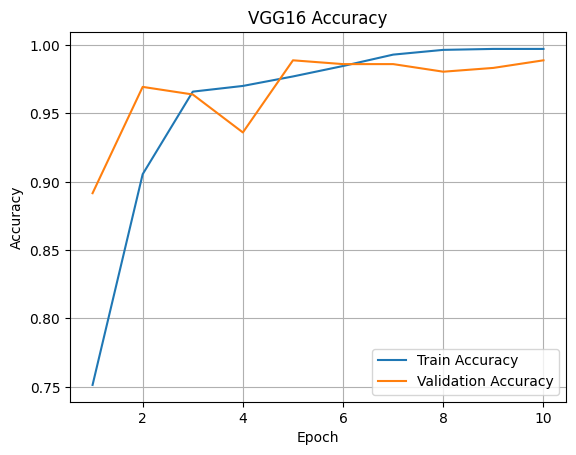

<Figure size 640x480 with 0 Axes>

In [ ]:
#Accuracy plot
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG16 Accuracy")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('AccVal_acc')

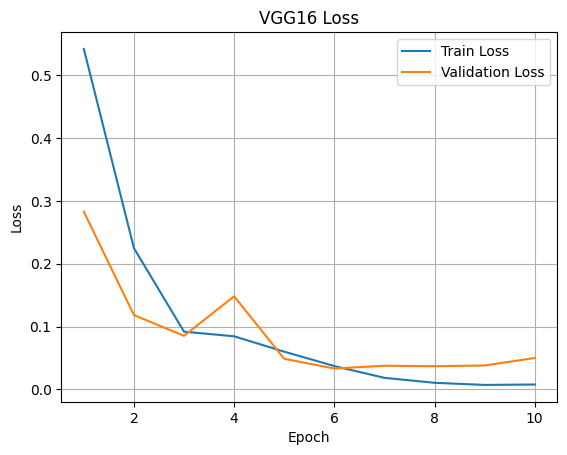

<Figure size 640x480 with 0 Axes>

In [ ]:
#Loss plot
plt.plot(range(1, num_epochs+1), vgg_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vgg_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG16 Loss")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('LossVal_loss')

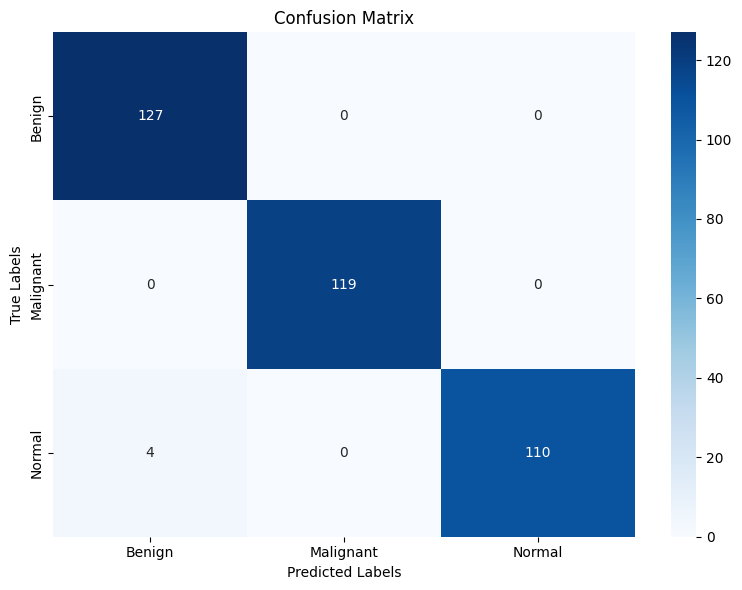

<Figure size 640x480 with 0 Axes>

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = ['Benign', 'Malignant', 'Normal']

#Plot Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.savefig('VGG16_confusion_matrix.png')

ResNet50

In [ ]:
##Training

#Laoding model
resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 3)

#movel to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

#Training loop
epochs = 10
rn_train_losses = []
rn_train_accuracies = []
rn_val_losses = []
rn_val_accuracies = []

for epoch in range(epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    rn_train_losses.append(epoch_loss)
    rn_train_accuracies.append(epoch_acc)

    #Validation loop
    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    rn_val_losses.append(val_loss / len(val_loader))
    rn_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {rn_val_losses[-1]:.4f}, Val Acc: {rn_val_accuracies[-1]:.4f}")

Epoch 1, Train Loss: 0.3168, Train Acc: 0.8736, Val Loss: 0.1427, Val Acc: 0.9361
Epoch 2, Train Loss: 0.0534, Train Acc: 0.9826, Val Loss: 0.0746, Val Acc: 0.9833
Epoch 3, Train Loss: 0.0749, Train Acc: 0.9764, Val Loss: 0.0847, Val Acc: 0.9806
Epoch 4, Train Loss: 0.0427, Train Acc: 0.9854, Val Loss: 0.0314, Val Acc: 0.9861
Epoch 5, Train Loss: 0.0197, Train Acc: 0.9944, Val Loss: 0.0238, Val Acc: 0.9944
Epoch 6, Train Loss: 0.0063, Train Acc: 0.9993, Val Loss: 0.0212, Val Acc: 0.9889
Epoch 7, Train Loss: 0.0058, Train Acc: 0.9986, Val Loss: 0.0208, Val Acc: 0.9944
Epoch 8, Train Loss: 0.0023, Train Acc: 1.0000, Val Loss: 0.0227, Val Acc: 0.9889
Epoch 9, Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 0.0196, Val Acc: 0.9917
Epoch 10, Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0179, Val Acc: 0.9917


In [ ]:
#summary of the model
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
#saving the trained model to output folder
torch.save(model, 'resnet_lung_cancer_model.pth')

ResNet50 Evaluation Metrics:
Accuracy: 0.99
Precision: 0.9917
Recall: 0.9917
F1 Score: 0.9917


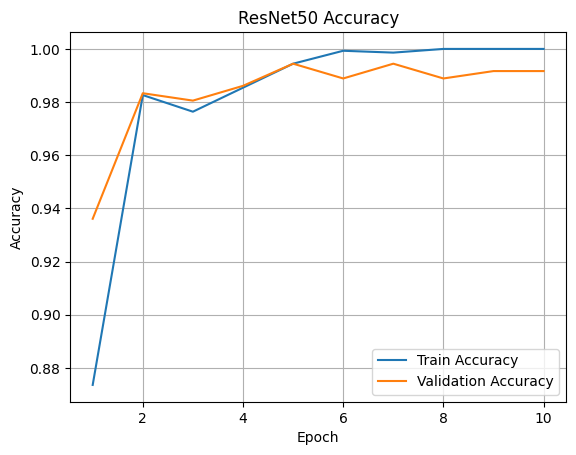

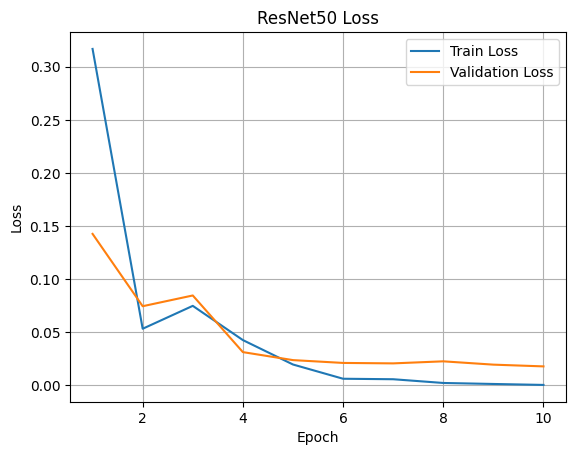

In [ ]:
epochs = 10

resnet50.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Converting to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

#Metrics calculaiton
resnet_metrics = {
    'Accuracy': round(correct / total, 2),
    'Precision': round(precision_score(y_true, y_pred, average='weighted'), 4),
    'Recall': round(recall_score(y_true, y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(y_true, y_pred, average='weighted'), 4)
}

#Print results
print("ResNet50 Evaluation Metrics:")
for key, value in resnet_metrics.items():
    if key != 'Model':
        print(f"{key}: {value}")

#Accuracy plot
plt.plot(range(1, epochs+1), rn_train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), rn_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Loss plot
plt.plot(range(1, epochs+1), rn_train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), rn_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Loss")
plt.legend()
plt.grid(True)
plt.show()

VGG19

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg19(pretrained=True)

#Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

#Replace the classifier
model.classifier[6] = nn.Linear(4096, 3)  #Number of classes: 3

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 101MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg19_train_losses = []
vgg19_train_accuracies = []
vgg19_val_losses = []
vgg19_val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    vgg19_train_losses.append(epoch_loss)
    vgg19_train_accuracies.append(epoch_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    vgg19_val_losses.append(val_loss / len(val_loader))
    vgg19_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Acc: {vgg_val_accuracies[-1]:.4f}")

Epoch 1, Train Loss: 0.5357, Train Acc: 0.7465, Val Loss: 0.2755, Val Acc: 0.8778
Epoch 2, Train Loss: 0.2207, Train Acc: 0.9125, Val Loss: 0.1267, Val Acc: 0.9444
Epoch 3, Train Loss: 0.1037, Train Acc: 0.9604, Val Loss: 0.0960, Val Acc: 0.9722
Epoch 4, Train Loss: 0.0585, Train Acc: 0.9840, Val Loss: 0.2019, Val Acc: 0.9250
Epoch 5, Train Loss: 0.0548, Train Acc: 0.9819, Val Loss: 0.0697, Val Acc: 0.9750
Epoch 6, Train Loss: 0.0567, Train Acc: 0.9785, Val Loss: 0.0817, Val Acc: 0.9722
Epoch 7, Train Loss: 0.0326, Train Acc: 0.9903, Val Loss: 0.0568, Val Acc: 0.9750
Epoch 8, Train Loss: 0.0156, Train Acc: 0.9944, Val Loss: 0.0571, Val Acc: 0.9778
Epoch 9, Train Loss: 0.0094, Train Acc: 0.9965, Val Loss: 0.0490, Val Acc: 0.9806
Epoch 10, Train Loss: 0.0122, Train Acc: 0.9951, Val Loss: 0.0595, Val Acc: 0.9778


In [ ]:
#summary of the model
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
#saving the trained model to output folder
torch.save(model, 'vgg19_lung_cancer_model.pth')

In [ ]:
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#converting to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

#metrics calculations
sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

In [ ]:
#Save to folder
vgg_metrics = {
    'Accuracy': round(sklearn_accuracy, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4)
}

print("VGG19 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

VGG19 Evaluation Metrics:
Accuracy: 0.9778
Precision: 0.9779
Recall: 0.9778
F1 Score: 0.9778


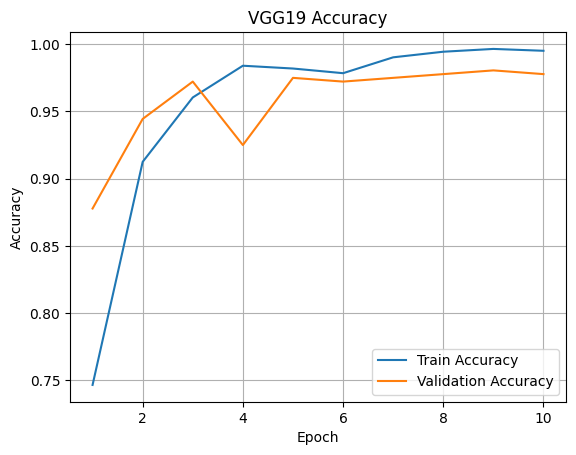

<Figure size 640x480 with 0 Axes>

In [ ]:
# Accuracy plot
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG19 Accuracy")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('AccVal_acc')

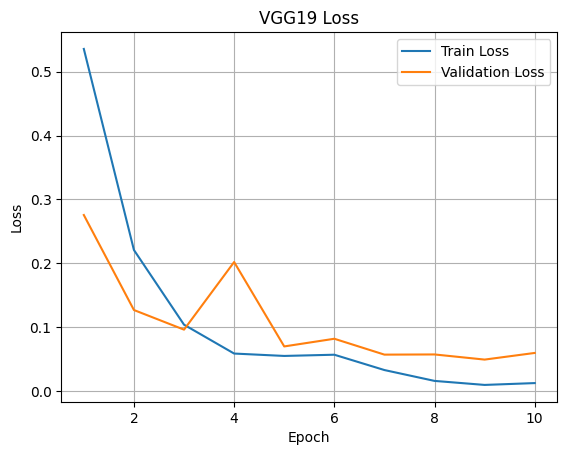

<Figure size 640x480 with 0 Axes>

In [ ]:
# Loss plot
plt.plot(range(1, num_epochs+1), vgg_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vgg_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG19 Loss")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('LossVal_loss')